In [1]:
# database and persisting
import sqlite3
import pickle

# date
import datetime

# vocab
from nltk.corpus import stopwords
from collections import Counter
from collections import defaultdict as dd

# review runtime
from tqdm import tqdm

# python packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime, timedelta, date

# data processesing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

# ARIMA
from pyramid.arima import auto_arima

# lstm
from keras.models import Sequential, Model, model_from_json
from keras.layers import LSTM, Dense, Dropout, Flatten, GRU, CuDNNLSTM
from keras.optimizers import SGD
import tensorflow as tf

# # GPU only
# from keras import backend as K
# cfg = K.tf.ConfigProto()
# cfg.gpu_options.allow_growth = True
# K.set_session(K.tf.Session(config=cfg))

Using TensorFlow backend.


In [2]:
# read in functions from python scripts
exec(open('python_scripts/model_functions.py').read())
exec(open('python_scripts/tokenization_functions.py').read())
exec(open('python_scripts/save_load_functions.py').read())

# Set seed for repeatable results
np.random.seed(1103)
tf.set_random_seed(1103)

# database connection
conn = sqlite3.connect('stocks_data/sp500_light.db')
c = conn.cursor()

# parameters
startdate = '2010-06-29'
enddate = '2018-12-31'

# stock dictionary
ticker2name = {'AAPL': 'apple', 'AMZN': 'amazon', 'DIS': 'disney', 'GS': 'goldman_sachs', 'TSLA': 'tesla'}

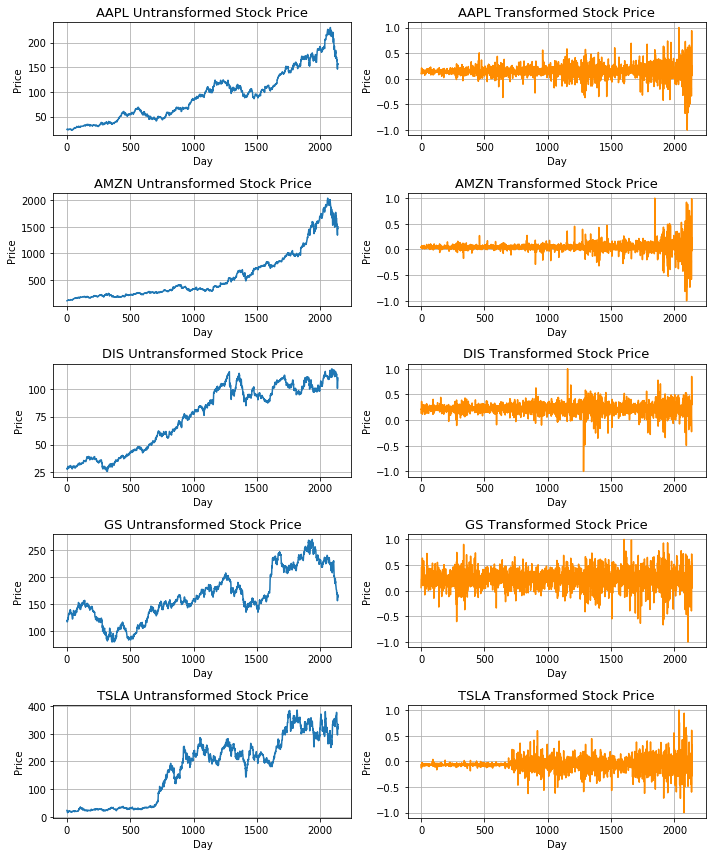

In [3]:
### GET SIMPLE PLOTS FOR STOCK PRICES ###

# plot shape
f, axarr = plt.subplots(len(ticker2name), 2, figsize=(10,12))

# iterate over each stock
for i in range(len(ticker2name)):
    sym = list(ticker2name.keys())[i]
    name = ticker2name[sym]
    
    # get stock data
    if sym == 'TSLA':
        hdata = pd.read_csv('stocks_data/' + name + '.csv')
    else:
        hdata = pd.read_sql("SELECT * FROM fact_table WHERE symbol='{}' AND date BETWEEN '{}' AND '{}'".format(sym, startdate, enddate), con=conn)
    # get time series
    ys = hdata['adj_close']
    hdata.drop(labels=['symbol'], axis=1, inplace=True)
    
    # modify for dictionary use
    hdata.columns = ['DATE', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'ADJ_CLOSE', 'VOLUME']

    # untransformed 
    fs = 10
    axarr[i,0].plot(np.array(ys), label=' untransformed price')
    axarr[i,0].set_title('{} Untransformed Stock Price'.format(sym), fontsize=fs*1.3)
    axarr[i,0].set_xlabel('Day', fontsize=fs)
    axarr[i,0].set_ylabel('Price', fontsize=fs)
    axarr[i,0].grid()
    
    # transformed
    scaler = MinMaxScaler(feature_range=(-1, 1))
    first_order_diffs = np.array(ys)[1:]-np.array(ys)[:-1]
    axarr[i,1].plot(scaler.fit_transform(first_order_diffs.reshape(-1,1)), 'darkorange', label='first order differenced and scaled price')
    axarr[i,1].set_title('{} Transformed Stock Price'.format(sym), fontsize=fs*1.3)
    axarr[i,1].set_xlabel('Day', fontsize=fs)
    axarr[i,1].set_ylabel('Price', fontsize=fs)
    axarr[i,1].grid()
    
# format and save
plt.tight_layout()
plt.savefig('plots/simple_prices.png', bbox_inches='tight')

In [4]:
# fixed hyperparameters
n_lag = 60
n_batch = 1
prop_test = .3
n_epochs = 50
fs = 10

In [5]:
# train models
for n_seq in [5, 20, 60]: 
    for i in range(len(ticker2name)):
        sym = list(ticker2name.keys())[i]
        name = ticker2name[sym]
        
        # generate inputs
        series, scaler, train, test, n_test = generate_inputs(sym, name) # arima and lstm
        series, n_test, scaler_mult, train_mult, test_mult = generate_inputs_mv(sym, name, gramtype) # lstm news
        
        ############
        ## ARIMA ###
        ############

        model_name = 'arima'
        n_neurons = 0

        # fit model and make forecasts, save forecasts
        forecasts = arima_fit_and_forecast(test, n_lag, n_seq)
        store_arima_forecasts(forecasts, model_name, name, n_epochs, n_neurons, n_lag, n_seq)
        
        # inverse transform forecasts and test
        forecasts = inverse_transform(series, forecasts, scaler, n_test)
        actual = [row[n_lag:] for row in test]
        actual = inverse_transform(series, actual, scaler, n_test)

        # evaluate forecasts and save test loss
        test_loss = evaluate_forecasts(actual, forecasts, n_lag, n_seq)
        store_test_rmses(test_loss, model_name, name, n_epochs, n_neurons, n_lag, n_seq)

        # plot forecasts
        plot_forecasts(series, forecasts, n_test, sym, n_neurons, n_seq, fs)
        
        for n_neurons in [10, 50, 100]:

            ############
            ### LSTM ###
            ############
            model_name = 'lstm'
            print(model_name, name, n_epochs, n_neurons, n_lag, n_seq)
            try:
                model = load_keras_model(model_name, name, n_epochs, n_neurons, n_lag, n_seq)
            except:
                # fit model and save model and train loss
                model, train_loss = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
                store_keras_model(model, model_name, name, n_epochs, n_neurons, n_lag, n_seq)
                store_train_rmses(train_loss, model_name, name, n_epochs, n_neurons, n_lag, n_seq)

                # make forecasts
                forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)

                # inverse transform forecasts and test
                forecasts = inverse_transform(series, forecasts, scaler, n_test)
                actual = [row[n_lag:] for row in test]
                actual = inverse_transform(series, actual, scaler, n_test)

                # evaluate forecasts and save test loss
                test_loss = evaluate_forecasts(actual, forecasts, n_lag, n_seq)
                store_test_rmses(test_loss, model_name, name, n_epochs, n_neurons, n_lag, n_seq)

                # plot train loss and forecasts
                plot_train_loss(train_loss, sym, n_neurons, n_seq, fs)
                plot_forecasts(series, forecasts, n_test, sym, n_neurons, n_seq, fs)
            
            #################
            ### LSTM News ###
            #################
            model_name = 'news'
            print(model_name, name, n_epochs, n_neurons, n_lag, n_seq)
            try:
                model = load_keras_model(model_name, name, n_epochs, n_neurons, n_lag, n_seq)
            except:                
                # fit model and save model and train loss
                model, train_loss = fit_lstm_mv(train_mult, n_lag, n_seq, n_batch, n_epochs, n_neurons)
                store_keras_model(model, model_name, name, n_epochs, n_neurons, n_lag, n_seq)
                store_train_rmses(train_loss, model_name, name, n_epochs, n_neurons, n_lag, n_seq)

                # make forecasts
                forecasts = make_forecasts_mv(model, n_batch, train_mult, test_mult, n_lag, n_seq)

                # inverse transform forecasts and test
                forecasts = inverse_transform(series, forecasts, scaler_mult, n_test)
                actual = [row[n_lag:] for row in test_mult[:,-1,:]]
                actual = inverse_transform(series, actual, scaler_mult, n_test)

                # evaluate forecasts and save test loss
                test_loss = evaluate_forecasts(actual, forecasts, n_lag, n_seq)
                store_test_rmses(test_loss, model_name, name, n_epochs, n_neurons, n_lag, n_seq)

                # plot train loss and forecasts
                plot_train_loss(train_loss, sym, n_neurons, n_seq, fs)
                plot_forecasts(series, forecasts, n_test, sym, n_neurons, n_seq, fs)

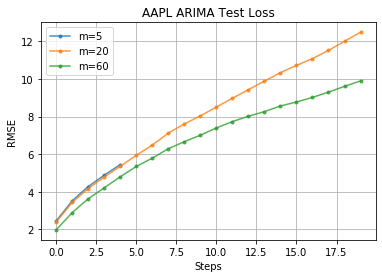

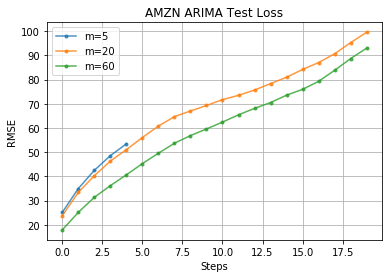

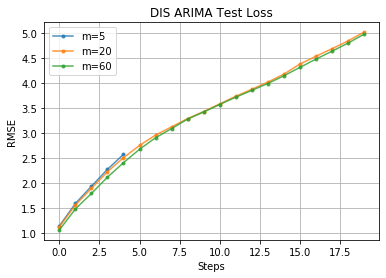

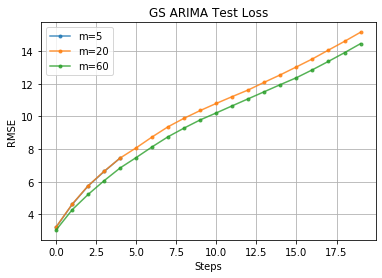

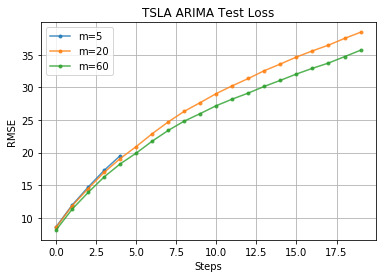

In [6]:
# plot test losses for arima
model_name = 'arima'
n_neurons = 0
for i in range(len(ticker2name)):
    sym = list(ticker2name.keys())[i]
    name = ticker2name[sym]
    plt.figure()
    plt.title('{} ARIMA Test Loss'.format(sym))
    plt.xlabel('Steps')
    plt.ylabel('RMSE')
    for n_seq in [5, 20, 60]:
        loaded_rmses = load_test_rmses(model_name, name, n_epochs, n_neurons, n_lag, n_seq)
        plt.plot(loaded_rmses[:20], '.-', label='m='+str(n_seq), alpha=.8)
    plt.legend()
    plt.grid()
    plt.xticks()
    plt.savefig('plots/testloss_arima_{}.png'.format(name), bbox_inches='tight')    

<Figure size 432x288 with 0 Axes>

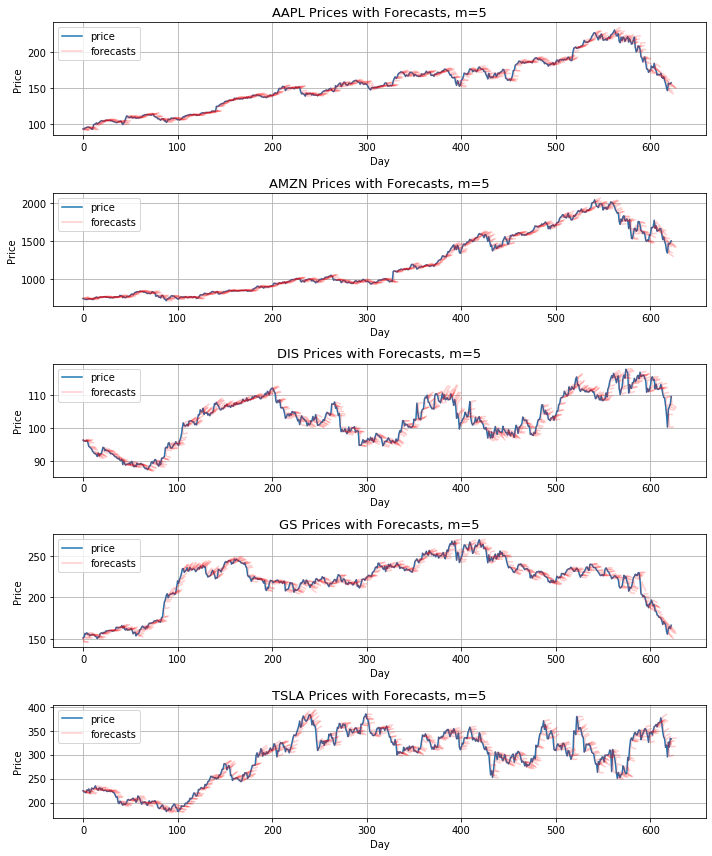

<Figure size 432x288 with 0 Axes>

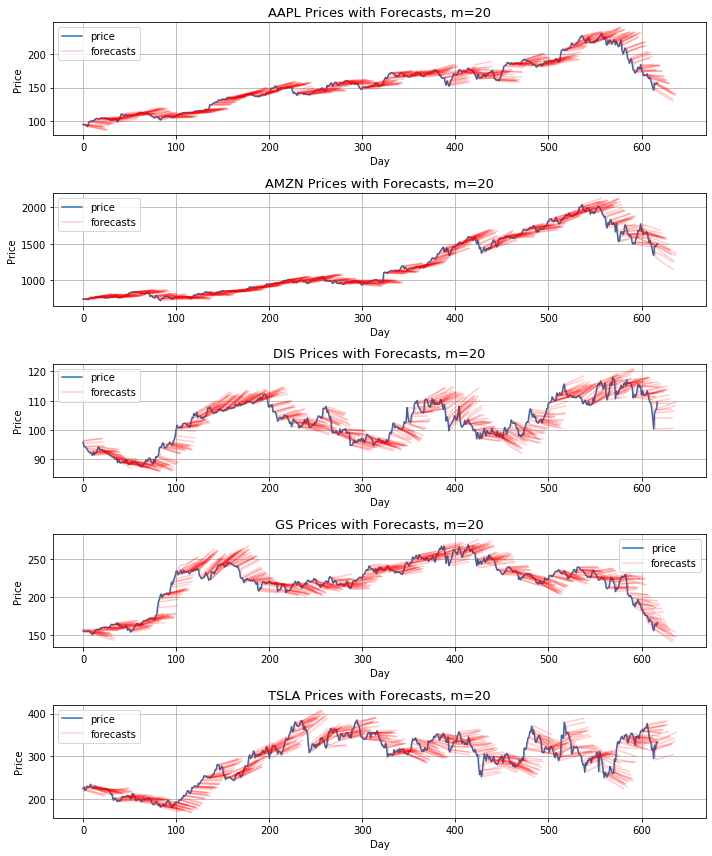

<Figure size 432x288 with 0 Axes>

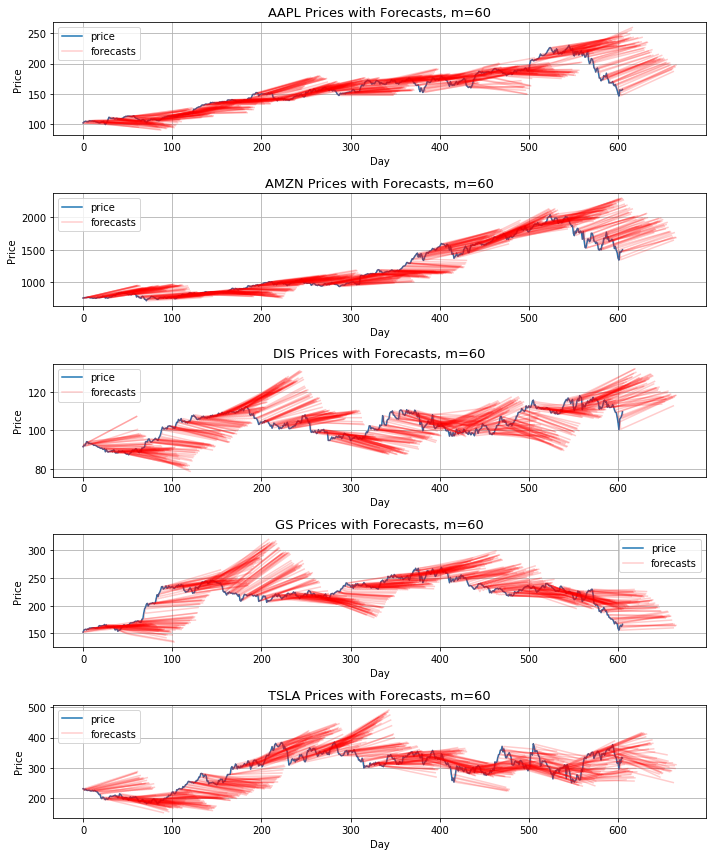

In [7]:
# arima forecast plots
model_name = 'arima'
n_neurons = 0
for n_seq in [5, 20, 60]:
    plt.figure()
    f, axarr = plt.subplots(5, 1, figsize=(10,12))
    for i in range(len(ticker2name)):
        sym = list(ticker2name.keys())[i]
        name = ticker2name[sym]

        # generate inputs
        series, scaler, train, test, n_test = generate_inputs(sym, name)
        
        # load forecasts
        forecasts = load_arima_forecasts(model_name, name, n_epochs, n_neurons, n_lag, n_seq)

        # inverse transform forecasts and test
        forecasts = inverse_transform(series, forecasts, scaler, n_test)
        actual = [row[n_lag:] for row in test]
        actual = inverse_transform(series, actual, scaler, n_test)

        # plot forecasts and save
        plot_arima_forecasts_grid(series, forecasts, n_seq, n_test, axarr, i, fs)
    plt.tight_layout()
    plt.savefig('plots/fplots_arima_{}.png'.format(n_seq), bbox_inches='tight')    

<Figure size 432x288 with 0 Axes>

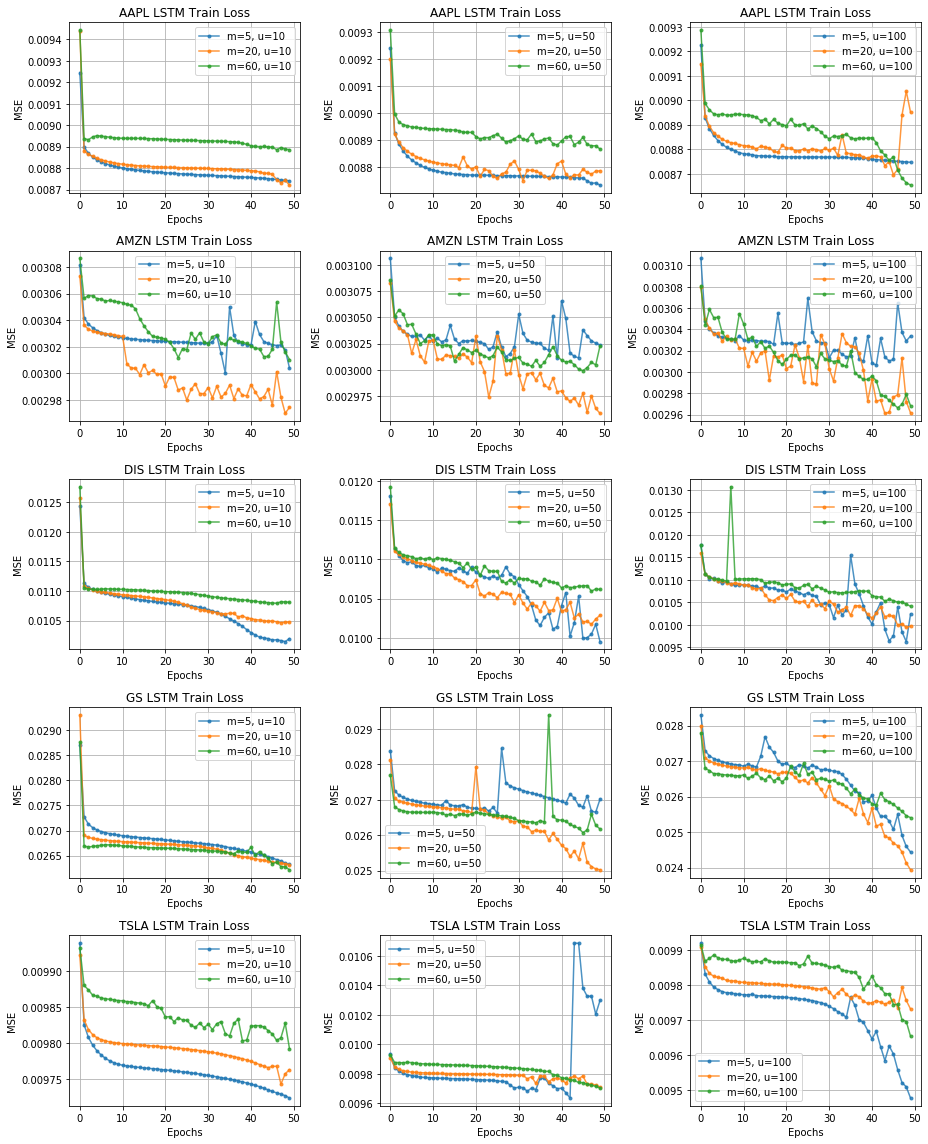

In [8]:
# plot train losses for LSTMs
model_name = 'lstm'
# model_name = 'news'
n_seqs = [5, 20, 60]
n_neuronss = [10, 50, 100]
plt.figure()
f, axarr = plt.subplots(5, 3, figsize=(13,16))
for i in range(len(ticker2name)):
    sym = list(ticker2name.keys())[i]
    name = ticker2name[sym]
    for j in range(len(n_neuronss)):
        n_neurons = n_neuronss[j]
        for k in range(len(n_seqs)):
            n_seq = n_seqs[k]
            loaded_rmses = load_train_rmses(model_name, name, n_epochs, n_neurons, n_lag, n_seq)
            axarr[i,j].set_title('{} LSTM Train Loss'.format(sym))#, fontsize=16)
#             axarr[i,j].set_title('{} LSTM w/News Train Loss'.format(sym))#, fontsize=16)
            axarr[i,j].set_xlabel('Epochs')#, fontsize=13)
            axarr[i,j].set_ylabel('MSE')#, fontsize=13)
            axarr[i,j].plot(loaded_rmses, '.-', label='m={}, u={}'.format(n_seq, n_neurons), alpha=.8)
        axarr[i,j].legend()
        axarr[i,j].grid()
plt.tight_layout()
plt.savefig('plots/trainloss_{}.png'.format(model_name), bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

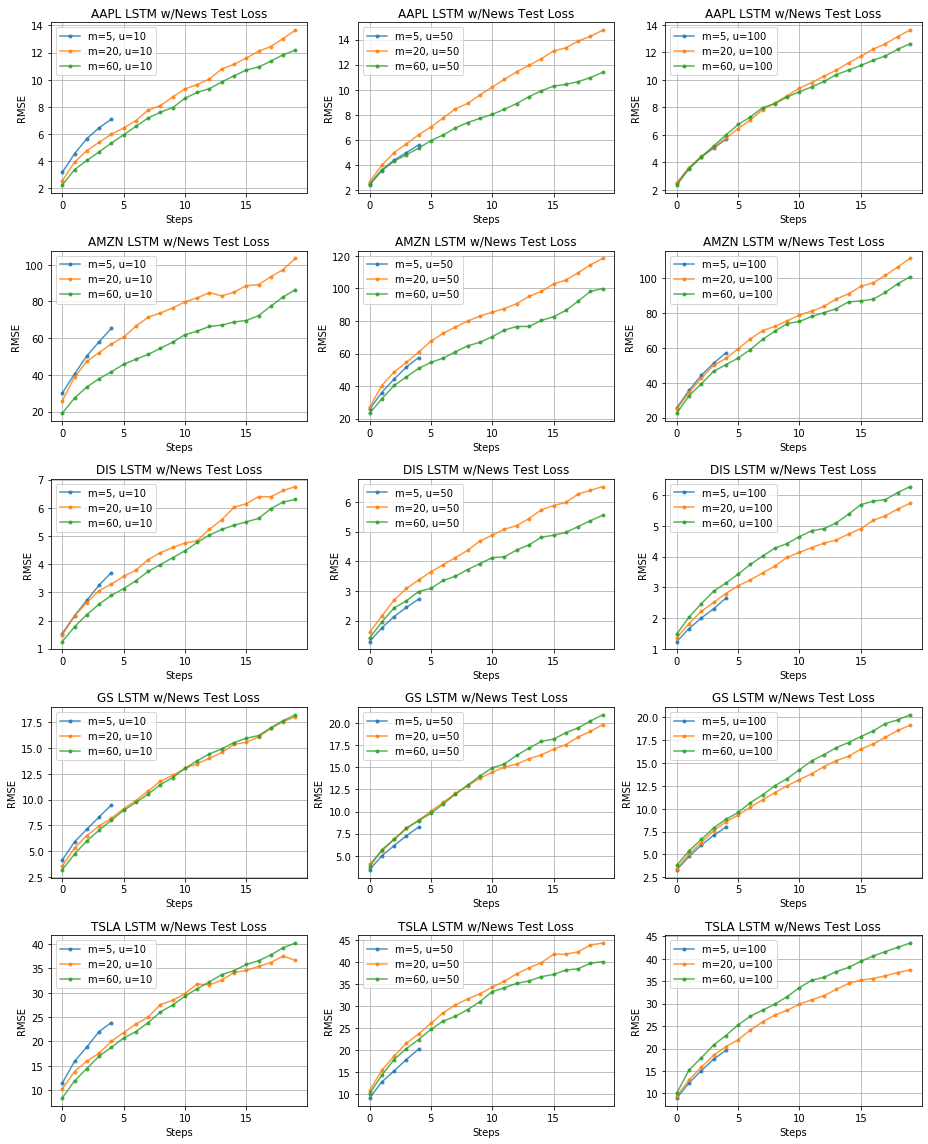

In [9]:
# plot test losses for LSTMs
# model_name = 'lstm'
model_name = 'news'
n_seqs = [5, 20, 60]
n_neuronss = [10, 50, 100]
plt.figure()
f, axarr = plt.subplots(5, 3, figsize=(13,16))
for i in range(len(ticker2name)):
    sym = list(ticker2name.keys())[i]
    name = ticker2name[sym]

#     # by steps 
#     savestring = 'bysteps'
#     for j in range(len(n_seqs)):
#         n_seq = n_seqs[j]
#         for k in range(len(n_neuronss)):
#             n_neurons = n_neuronss[k]
    # by neurons
    savestring = 'byneurons'
    for j in range(len(n_neuronss)):
        n_neurons = n_neuronss[j]
        for k in range(len(n_seqs)):
            n_seq = n_seqs[k]
            
            # plot
            loaded_rmses = load_test_rmses(model_name, name, n_epochs, n_neurons, n_lag, n_seq)
#             axarr[i,j].set_title('{} LSTM Test Loss'.format(sym))#, fontsize=16)
            axarr[i,j].set_title('{} LSTM w/News Test Loss'.format(sym))#, fontsize=16)
            axarr[i,j].set_xlabel('Steps')#, fontsize=13)
            axarr[i,j].set_ylabel('RMSE')#, fontsize=13)
            axarr[i,j].plot(loaded_rmses[:20], '.-', label='m={}, u={}'.format(n_seq, n_neurons), alpha=.8)
        axarr[i,j].legend()
        axarr[i,j].grid()
plt.tight_layout()
plt.savefig('plots/testloss_{}_{}.png'.format(model_name, savestring), bbox_inches='tight')    

In [10]:
# lstm forecast plots
n_neuronss = [10, 50, 100]
model_name = 'lstm'
for i in range(len(ticker2name)):
    sym = list(ticker2name.keys())[i]
    name = ticker2name[sym]
    for n_seq in [5, 20, 60]: 

        # generate inputs
        series, scaler, train, test, n_test = generate_inputs(sym, name)

        for j in range(len(n_neuronss)):
            n_neurons = n_neuronss[j]
            
            # load model and loss
            model = load_keras_model(model_name, name, n_epochs, n_neurons, n_lag, n_seq)

            # make forecasts
            forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)

            # inverse transform forecasts and test
            forecasts = inverse_transform(series, forecasts, scaler, n_test)
            actual = [row[n_lag:] for row in test]
            actual = inverse_transform(series, actual, scaler, n_test)
        
            # plot forecasts and save
            plt.figure()
            plot_forecasts(series, forecasts, n_test, sym, n_neurons, n_seq, fs)
            plt.savefig('plots/fplots_{}_{}_{}_{}.png'.format(model_name, name, n_seq, n_neurons))  
            plt.show()

In [11]:
# lstm news forecast plots
n_neuronss = [10, 50, 100]
model_name = 'news'
for i in range(len(ticker2name)):
    sym = list(ticker2name.keys())[i]
    name = ticker2name[sym]
    for n_seq in [5, 20, 60]: 

        # generate inputs
        series, scaler, train, test, n_test = generate_inputs(sym, name)
        series, n_test, scaler_mult, train_mult, test_mult = generate_inputs_mv(sym, name, 'onegram')

        for j in range(len(n_neuronss)):
            n_neurons = n_neuronss[j]
            
            # load model and loss
            model = load_keras_model(model_name, name, n_epochs, n_neurons, n_lag, n_seq)

            # make forecasts
            forecasts = make_forecasts_mv(model, n_batch, train_mult, test_mult, n_lag, n_seq)

            # inverse transform forecasts and test
            forecasts = inverse_transform(series, forecasts, scaler_mult, n_test)
            actual = [row[n_lag:] for row in test_mult[:,-1,:]]
            actual = inverse_transform(series, actual, scaler_mult, n_test)
        
            # plot forecasts and save
            plt.figure()
            plot_forecasts(series, forecasts, n_test, sym, n_neurons, n_seq, fs)
            plt.savefig('plots/fplots_{}_{}_{}_{}.png'.format(model_name, name, n_seq, n_neurons))   
            plt.show()

<Figure size 432x288 with 0 Axes>

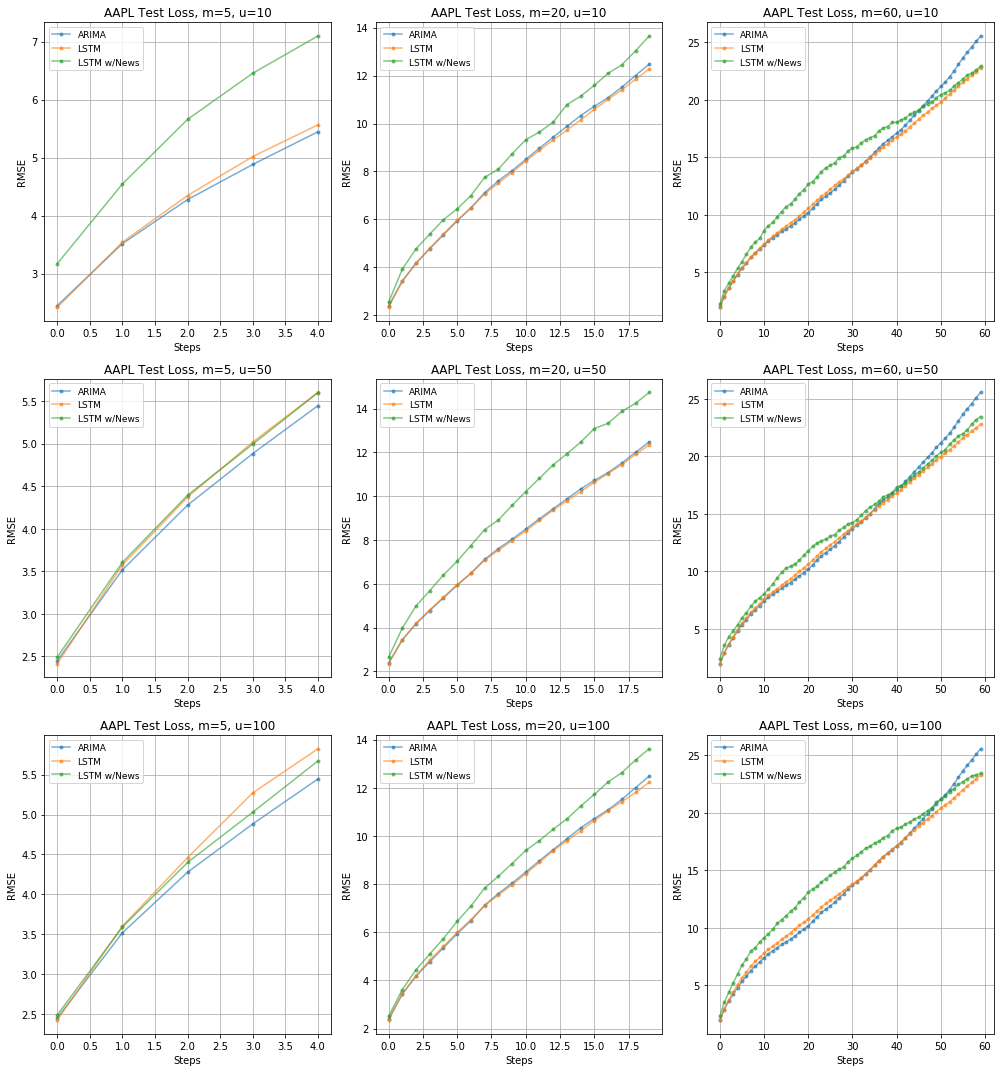

<Figure size 432x288 with 0 Axes>

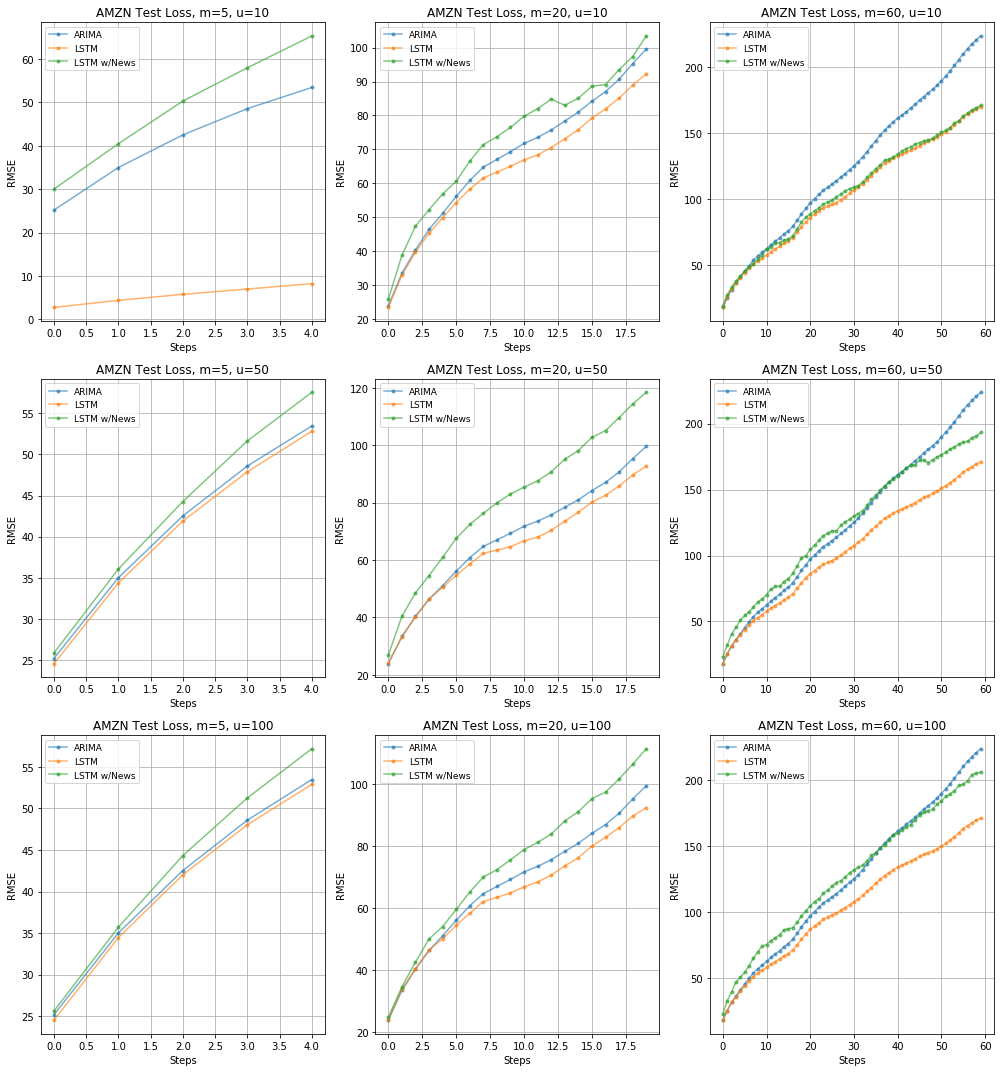

<Figure size 432x288 with 0 Axes>

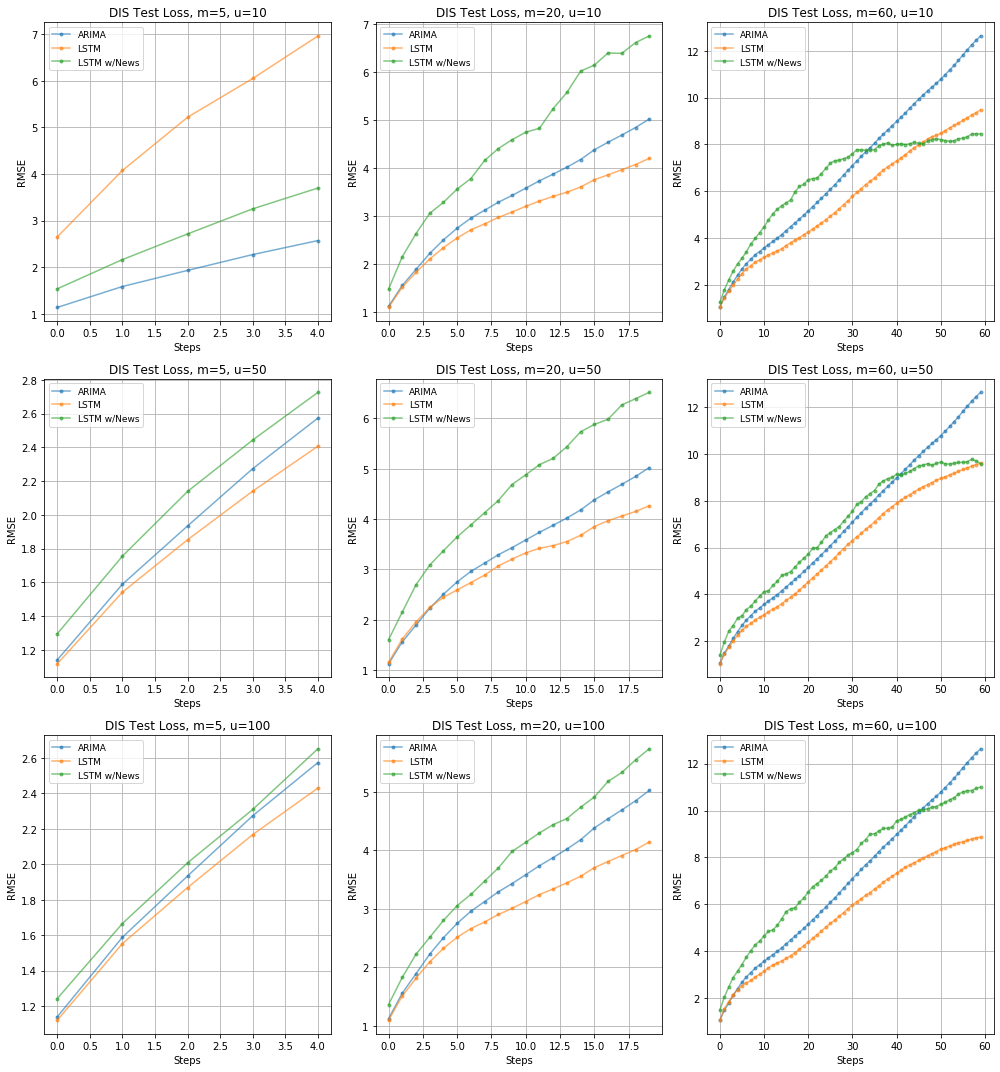

<Figure size 432x288 with 0 Axes>

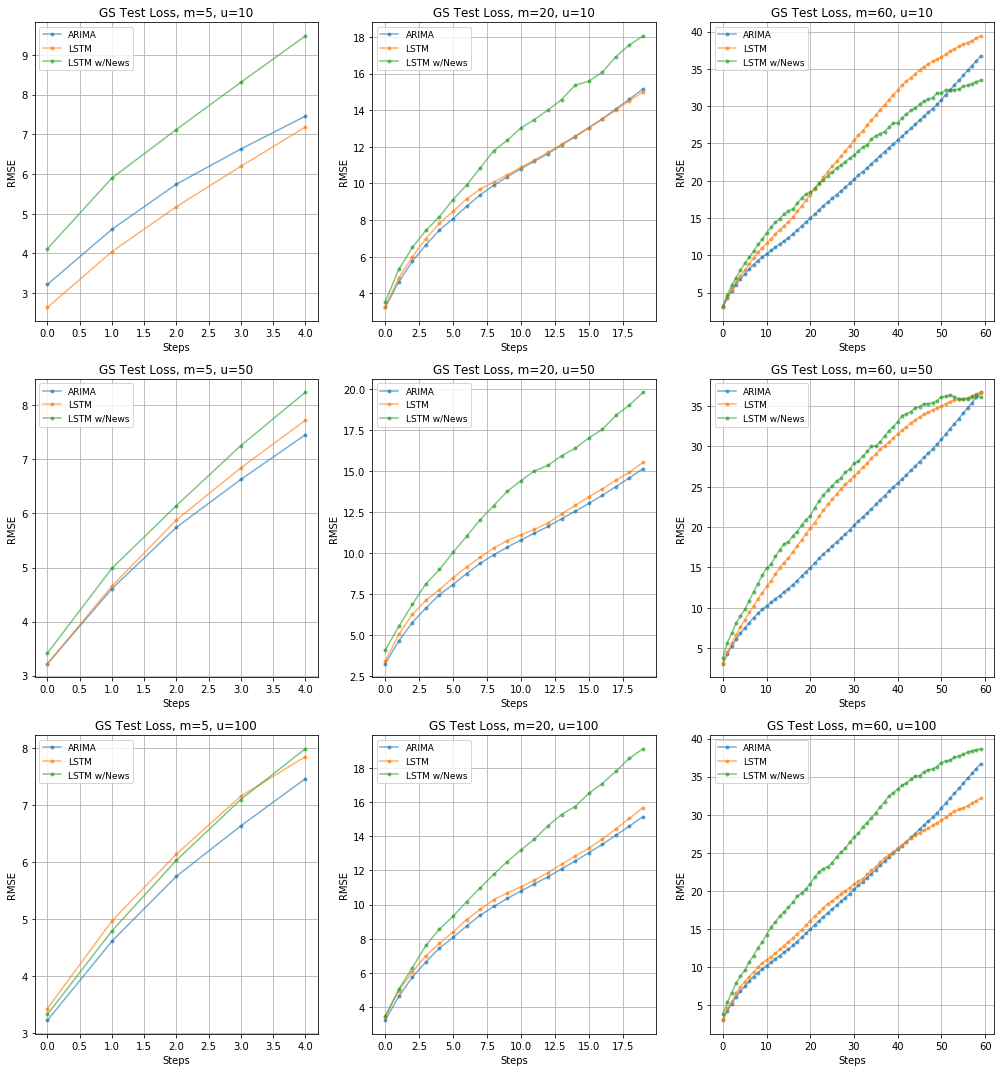

<Figure size 432x288 with 0 Axes>

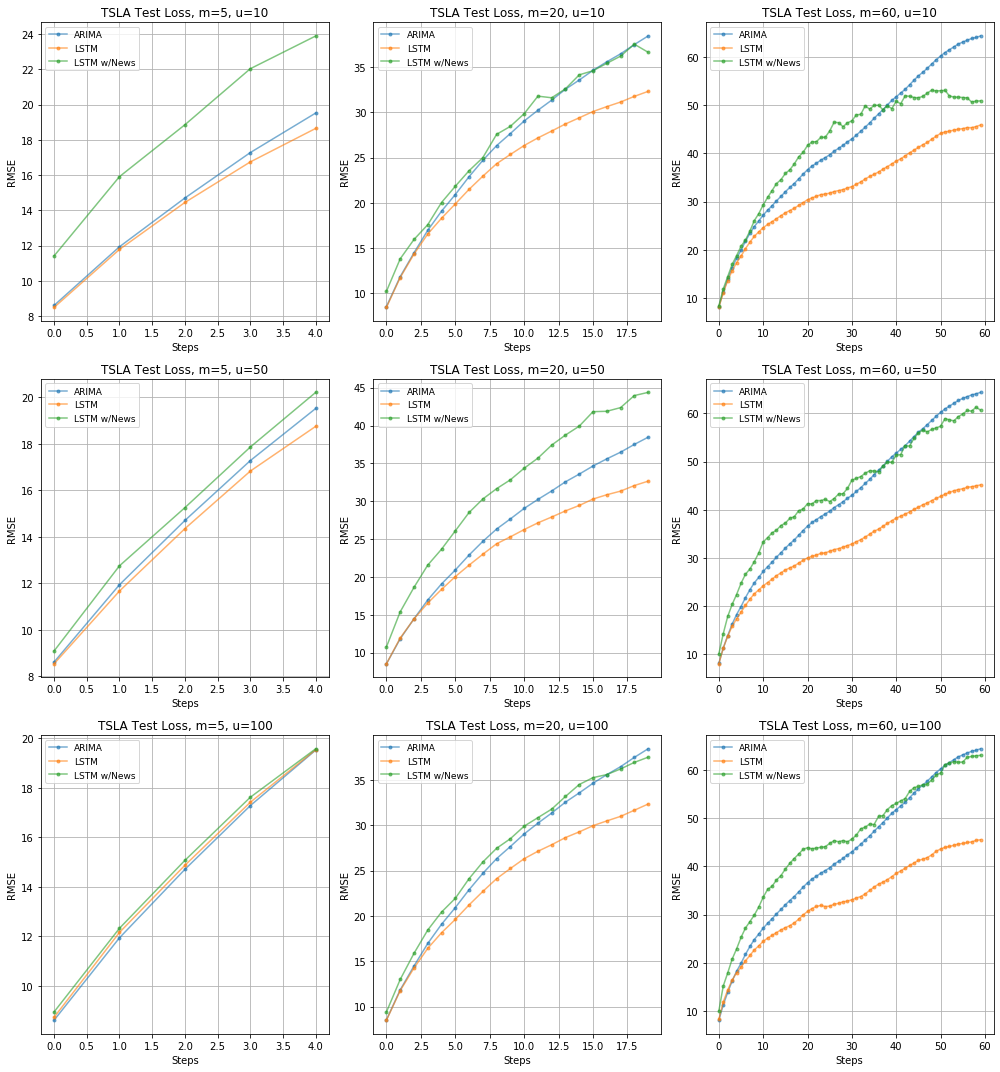

In [12]:
# compare loss between all models
n_seqs = [5, 20, 60]
n_neuronss = [10, 50, 100]
for i in range(len(ticker2name)):
    sym = list(ticker2name.keys())[i]
    name = ticker2name[sym]    
    plt.figure()
    f, axarr = plt.subplots(3, 3, figsize=(14,15))
    for j in range(len(n_neuronss)):
        n_neurons = n_neuronss[j]
        for k in range(len(n_seqs)):
            n_seq = n_seqs[k]
            
            # load losses
            model_name = 'arima'
            test_loss_arima = load_test_rmses(model_name, name, n_epochs, 0, n_lag, n_seq)
            model_name = 'lstm'
            test_loss_lstm = load_test_rmses(model_name, name, n_epochs, n_neurons, n_lag, n_seq)
            model_name = 'news'
            test_loss_news = load_test_rmses(model_name, name, n_epochs, n_neurons, n_lag, n_seq)
            
            # plot
            axarr[j,k].set_title('{} Test Loss, m={}, u={}'.format(sym, n_seq, n_neurons))#, fontsize=16)
            axarr[j,k].set_xlabel('Steps')#, fontsize=13)
            axarr[j,k].set_ylabel('RMSE')#, fontsize=13)
            axarr[j,k].plot(test_loss_arima, '.-', alpha=.6, label='ARIMA')
            axarr[j,k].plot(test_loss_lstm, '.-', alpha=.6, label='LSTM')
            axarr[j,k].plot(test_loss_news, '.-', alpha=.6, label='LSTM w/News')
            axarr[j,k].legend(fontsize=9)
            axarr[j,k].grid()
    plt.tight_layout()
    plt.savefig('plots/testloss_{}_{}_{}.png'.format('all', name, 'comparison'), bbox_inches='tight')   

In [13]:
######################################
### LSTM News Bigrams and Trigrams ###
######################################
model_name = 'news'

# parameters
n_seq = 60
sym = 'DIS'
name = ticker2name[sym]
for n_neurons in [10, 50, 100]:
    for gramtype in ['bigram', 'trigram']:
        print(model_name, name, n_epochs, n_neurons, n_lag, n_seq, gramtype)

        # generate inputs
#         series, scaler, train, test, n_test = generate_inputs(sym, name) # arima and lstm
        series, n_test, scaler_mult, train_mult, test_mult = generate_inputs_mv(sym, name, gramtype) # lstm news

        try:
            model = load_keras_model(model_name + gramtype, name, n_epochs, n_neurons, n_lag, n_seq)
        except:                
            # fit model and save model and train loss
            model, train_loss = fit_lstm_mv(train_mult, n_lag, n_seq, n_batch, n_epochs, n_neurons)
            store_keras_model(model, model_name + gramtype, name, n_epochs, n_neurons, n_lag, n_seq)
            store_train_rmses(train_loss, model_name + gramtype, name, n_epochs, n_neurons, n_lag, n_seq)

        # make forecasts
        forecasts = make_forecasts_mv(model, n_batch, train_mult, test_mult, n_lag, n_seq)

        # inverse transform forecasts and test
        forecasts = inverse_transform(series, forecasts, scaler_mult, n_test)
        actual = [row[n_lag:] for row in test_mult[:,-1,:]]
        actual = inverse_transform(series, actual, scaler_mult, n_test)

        # evaluate forecasts and save test loss
        test_loss = evaluate_forecasts(actual, forecasts, n_lag, n_seq)
        store_test_rmses(test_loss, model_name + gramtype, name, n_epochs, n_neurons, n_lag, n_seq)

        # plot train loss and forecasts
        plot_train_loss(train_loss, sym, n_neurons, n_seq, fs)
        plot_forecasts(series, forecasts, n_test, sym, n_neurons, n_seq, fs)
        
        # save plot
        plt.savefig('plots/fplots_{}_{}_{}_{}.png'.format(model_name + gramtype, name, n_seq, n_neurons))  
        
        # check
        print(np.array(test_loss) - np.array(load_test_rmses(model_name, name, n_epochs, n_neurons, n_lag, n_seq)))

In [14]:
#######################
### LSTM ARIMA News ###
#######################
model_name = 'arima_news'
gramtype = 'onegram'

# parameters
n_seq = 60
sym = 'DIS'
name = ticker2name[sym]
for n_neurons in [10, 50, 100]:
    for gramtype in ['onegram', 'bigram', 'trigram']:
        print(model_name, name, n_epochs, n_neurons, n_lag, n_seq, gramtype)

        # generate inputs
        series, scaler, train, test, n_test = generate_inputs(sym, name) # arima and lstm
        series, n_test, scaler_mult, train_mult, test_mult = generate_inputs_mv(sym, name, gramtype) # lstm news

        # ARIMA boost data from fitted and forecasts
        try:
            arima_train_data, arima_test_data = load_arima_boost_data('boost', name, n_epochs, 0, n_lag, n_seq)
        except:
            arima_train_data = arima_boost_data(train, n_lag, n_seq)
            arima_test_data = arima_boost_data(test, n_lag, n_seq)
            store_arima_boost_data((arima_train_data, arima_test_data), 'boost', name, n_epochs, 0, n_lag, n_seq)
            
        # ARIMA enriched data sets
        arima_train_data = np.array(arima_train_data).reshape(len(arima_train_data), 1, len(arima_train_data[0]))
        arima_test_data = np.array(arima_test_data).reshape(len(arima_test_data), 1, len(arima_test_data[0]))
        train_mult = np.concatenate((train_mult, arima_train_data), axis=1)
        test_mult = np.concatenate((test_mult, arima_test_data), axis=1)

        # fit model and save model and train loss
        model, train_loss = fit_lstm_mv(train_mult, n_lag, n_seq, n_batch, n_epochs, n_neurons)
        store_keras_model(model, model_name + gramtype, name, n_epochs, n_neurons, n_lag, n_seq)
        store_train_rmses(train_loss, model_name + gramtype, name, n_epochs, n_neurons, n_lag, n_seq)

        # make forecasts
        forecasts = make_forecasts_mv(model, n_batch, train_mult, test_mult, n_lag, n_seq)

        # inverse transform forecasts and test
        forecasts = inverse_transform(series, forecasts, scaler_mult, n_test)
        actual = [row[n_lag:] for row in test_mult[:,-1,:]]
        actual = inverse_transform(series, actual, scaler_mult, n_test)

        # evaluate forecasts and save test loss
        test_loss = evaluate_forecasts(actual, forecasts, n_lag, n_seq)
        store_test_rmses(test_loss, model_name + gramtype, name, n_epochs, n_neurons, n_lag, n_seq)

        # plot train loss and forecasts
        plot_train_loss(train_loss, sym, n_neurons, n_seq, fs)
        plot_forecasts(series, forecasts, n_test, sym, n_neurons, n_seq, fs)
        
        # save plot
        plt.savefig('plots/fplots_{}_{}_{}_{}.png'.format(model_name + gramtype, name, n_seq, n_neurons))  
        
        # check
        print(np.array(test_loss) - np.array(load_test_rmses('news', name, n_epochs, n_neurons, n_lag, n_seq)))

<Figure size 432x288 with 0 Axes>

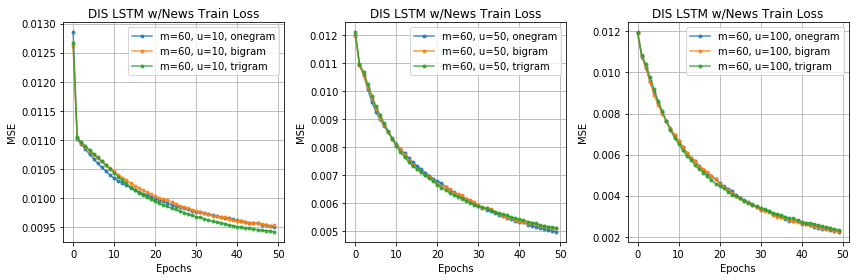

In [15]:
# plot train losses for disney over grams
model_name = 'news'
n_seq = 60
n_neuronss = [10, 50, 100]
plt.figure()
f, axarr = plt.subplots(1, 3, figsize=(12,4))
sym = 'DIS'
name = ticker2name[sym]
gramtypes = ['', 'bigram', 'trigram']
gramtypes_plotting = ['onegram', 'bigram', 'trigram']
for i in range(len(gramtypes)):
    gramtype = gramtypes[i]
    for j in range(len(n_neuronss)):
        n_neurons = n_neuronss[j]
        loaded_rmses = load_train_rmses(model_name + gramtype, name, n_epochs, n_neurons, n_lag, n_seq)
        axarr[j].set_title('{} LSTM w/News Train Loss'.format(sym))#, fontsize=16)
        axarr[j].set_xlabel('Epochs')#, fontsize=13)
        axarr[j].set_ylabel('MSE')#, fontsize=13)
        axarr[j].plot(loaded_rmses, '.-', label='m={}, u={}, {}'.format(n_seq, n_neurons, gramtypes_plotting[i]), alpha=.8)
        axarr[j].legend()
        axarr[j].grid()
plt.tight_layout()
plt.savefig('plots/trainloss_onebitri.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

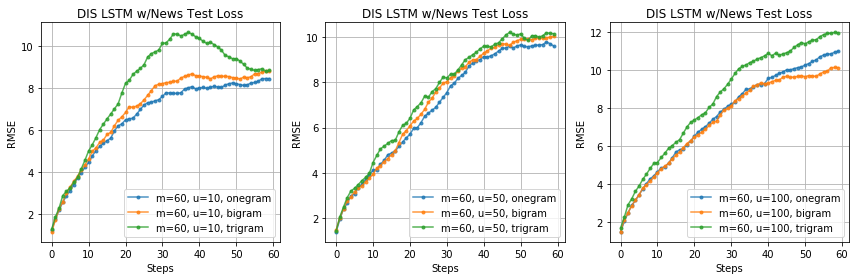

In [16]:
# plot test losses for disney over grams
model_name = 'news'
n_seq = 60
n_neuronss = [10, 50, 100]
plt.figure()
f, axarr = plt.subplots(1, 3, figsize=(12,4))
sym = 'DIS'
name = ticker2name[sym]
gramtypes = ['', 'bigram', 'trigram']
gramtypes_plotting = ['onegram', 'bigram', 'trigram']
for i in range(len(gramtypes)):
    gramtype = gramtypes[i]
    for j in range(len(n_neuronss)):
        n_neurons = n_neuronss[j]
        loaded_rmses = load_test_rmses(model_name + gramtype, name, n_epochs, n_neurons, n_lag, n_seq)
        axarr[j].set_title('{} LSTM w/News Test Loss'.format(sym))#, fontsize=16)
        axarr[j].set_xlabel('Steps')#, fontsize=13)
        axarr[j].set_ylabel('RMSE')#, fontsize=13)
        axarr[j].plot(loaded_rmses, '.-', label='m={}, u={}, {}'.format(n_seq, n_neurons, gramtypes_plotting[i]), alpha=.8)
        axarr[j].legend()
        axarr[j].grid()
plt.tight_layout()
plt.savefig('plots/testloss_onebitri.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

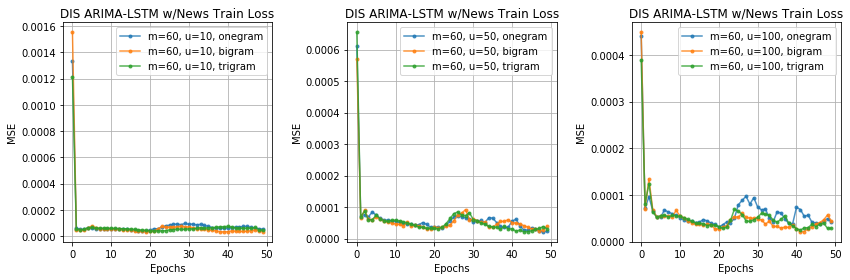

In [17]:
# plot train losses for disney with arima-enrichment
model_name = 'arima_news'
n_seq = 60
n_neuronss = [10, 50, 100]
plt.figure()
f, axarr = plt.subplots(1, 3, figsize=(12,4))
sym = 'DIS'
name = ticker2name[sym]
gramtypes = ['onegram', 'bigram', 'trigram']
for i in range(len(gramtypes)):
    gramtype = gramtypes[i]
    for j in range(len(n_neuronss)):
        n_neurons = n_neuronss[j]
        loaded_rmses = load_train_rmses(model_name + gramtype, name, n_epochs, n_neurons, n_lag, n_seq)
        axarr[j].set_title('{} ARIMA-LSTM w/News Train Loss'.format(sym))#, fontsize=16)
        axarr[j].set_xlabel('Epochs')#, fontsize=13)
        axarr[j].set_ylabel('MSE')#, fontsize=13)
        axarr[j].plot(loaded_rmses, '.-', label='m={}, u={}, {}'.format(n_seq, n_neurons, gramtype), alpha=.8)
        axarr[j].legend()
        axarr[j].grid()
plt.tight_layout()
plt.savefig('plots/trainloss_DISNEY.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

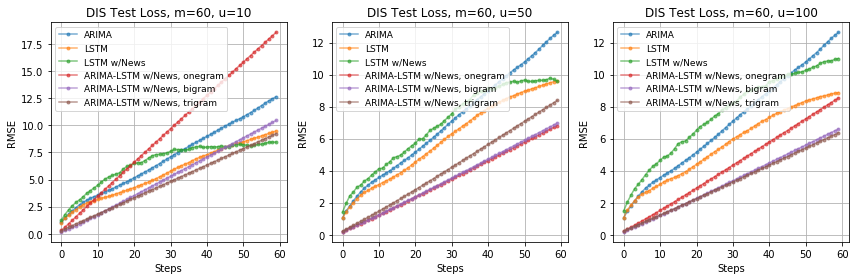

In [18]:
# compare loss between disney models
model = 'arima_news'
gramtype = 'trigram'
n_seq = 60
n_neuronss = [10, 50, 100]
sym = 'DIS'
name = ticker2name[sym] 
plt.figure()
f, axarr = plt.subplots(1, 3, figsize=(12,4))
for j in range(len(n_neuronss)):
    n_neurons = n_neuronss[j]

    # load losses
    model_name = 'arima'
    test_loss_arima = load_test_rmses(model_name, name, n_epochs, 0, n_lag, n_seq)
    model_name = 'lstm'
    test_loss_lstm = load_test_rmses(model_name, name, n_epochs, n_neurons, n_lag, n_seq)
    model_name = 'news'
    test_loss_news = load_test_rmses(model_name, name, n_epochs, n_neurons, n_lag, n_seq)
    model_name = 'arima_news'
    test_loss_arima_news_onegram = load_test_rmses(model_name + 'onegram', name, n_epochs, n_neurons, n_lag, n_seq)
    model_name = 'arima_news'
    test_loss_arima_news_bigram = load_test_rmses(model_name + 'bigram', name, n_epochs, n_neurons, n_lag, n_seq)
    model_name = 'arima_news'
    test_loss_arima_news_trigram = load_test_rmses(model_name + 'trigram', name, n_epochs, n_neurons, n_lag, n_seq)
    
#     # table of rmses
#     for i in range(n_seq):
#         string = '{} & {} & {} & {} & {} & {} & {} \\\\'.format(i+1, np.round(test_loss_arima[i],3), 
#                                                                      np.round(test_loss_lstm[i],3),
#                                                                      np.round(test_loss_news[i], 3), 
#                                                                      np.round(test_loss_arima_news_onegram[i], 3),
#                                                                      np.round(test_loss_arima_news_bigram[i], 3), 
#                                                                      np.round(test_loss_arima_news_trigram[i], 3))
#         print(string)
#     print('\n')
    
    # plot
    axarr[j].set_title('{} Test Loss, m={}, u={}'.format(sym, n_seq, n_neurons))#, fontsize=16)
    axarr[j].set_xlabel('Steps')#, fontsize=13)
    axarr[j].set_ylabel('RMSE')#, fontsize=13)
    axarr[j].plot(test_loss_arima, '.-', alpha=.6, label='ARIMA')
    axarr[j].plot(test_loss_lstm, '.-', alpha=.6, label='LSTM')
    axarr[j].plot(test_loss_news, '.-', alpha=.6, label='LSTM w/News')
    axarr[j].plot(test_loss_arima_news_onegram, '.-', alpha=.6, label='ARIMA-LSTM w/News, onegram')
    axarr[j].plot(test_loss_arima_news_bigram, '.-', alpha=.6, label='ARIMA-LSTM w/News, bigram')
    axarr[j].plot(test_loss_arima_news_trigram, '.-', alpha=.6, label='ARIMA-LSTM w/News, trigram')
    axarr[j].legend(fontsize=9)
    axarr[j].grid()
plt.tight_layout()
plt.savefig('plots/testloss_DISNEY.png'.format('all', name, 'comparison'), bbox_inches='tight')   